In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 设置参数
sc.settings.verbosity = 4
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=300,
    facecolor="white",
    frameon=False,  # remove frame
)

 11.注释
- 11.1 加载和准备数据
- 11.2 下载和加载celltypist模型
- 11.3 细胞类型注释
- 11.4 可视化结果
- 11.5 分析之前的手动注释
- 11.6 进一步分析

In [52]:
# 11.1 加载要自动注释的数据
adata = sc.read("anndata_cluster.h5ad")
# 11.1.1 复制adata以备后续处理
adata_celltypist = adata.copy()
# 11.1.2 将 .X 设置为原始计数
adata_celltypist.X = adata.layers["counts"]
# 11.1.3 归一化和对数变换
sc.pp.normalize_per_cell(adata_celltypist, counts_per_cell_after=10**4)
sc.pp.log1p(adata_celltypist)
# 这里传前面scran归一化的数据可能合适
adata_celltypist.X = adata_celltypist.X.toarray()

normalizing by total count per cell


/home/fanxi/mambaforge/envs/lang/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [53]:
# 11.2 下载和加载celltypist模型
import celltypist
from celltypist import models
models.download_models(force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"])

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 44
📂 Storing models in /home/fanxi/.celltypist/data/models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


In [54]:
# 11.2.1 加载低分辨率和高分辨率模型
celltypist.models.models_description()
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")

👉 Detailed model information can be found at `https://www.celltypist.org/models`


In [55]:
# 11.3 细胞类型注释
# 11.3.1 使用高分辨率模型进行细胞类型注释
predictions_high = celltypist.annotate(adata_celltypist, model=model_high, majority_voting=True)

🔬 Input data has 26051 cells and 6000 genes
🔗 Matching reference genes in the model
🧬 2893 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15


running Leiden clustering
    finished: found 270 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:13)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [56]:
# 11.3.2 将注释结果转化为AnnData对象
predictions_high_adata = predictions_high.to_adata()

In [57]:
# 11.3.3 添加高分辨率细胞类型信息和置信度分数到原始adata
adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[adata.obs.index, "majority_voting"]
adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[adata.obs.index, "conf_score"]
# 清理没使用到的分类
adata.obs["celltypist_cell_label_coarse"] = adata.obs["celltypist_cell_label_coarse"].cat.remove_unused_categories()

In [58]:
# 11.3.4 使用低分辨率模型进行细胞类型注释
predictions_low = celltypist.annotate(adata_celltypist, model=model_low, majority_voting=True)

🔬 Input data has 26051 cells and 6000 genes
🔗 Matching reference genes in the model
🧬 2893 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15


running Leiden clustering
    finished: found 270 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:13)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [59]:
# 11.3.5 将注释结果转化为AnnData对象
predictions_low_adata = predictions_low.to_adata()

In [60]:
# 11.3.6 添加低分辨率细胞类型信息和置信度分数到原始adata
adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[adata.obs.index, "majority_voting"]
adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[adata.obs.index, "conf_score"]
# 清理没使用到的分类
adata.obs["celltypist_cell_label_fine"] = adata.obs["celltypist_cell_label_fine"].cat.remove_unused_categories()

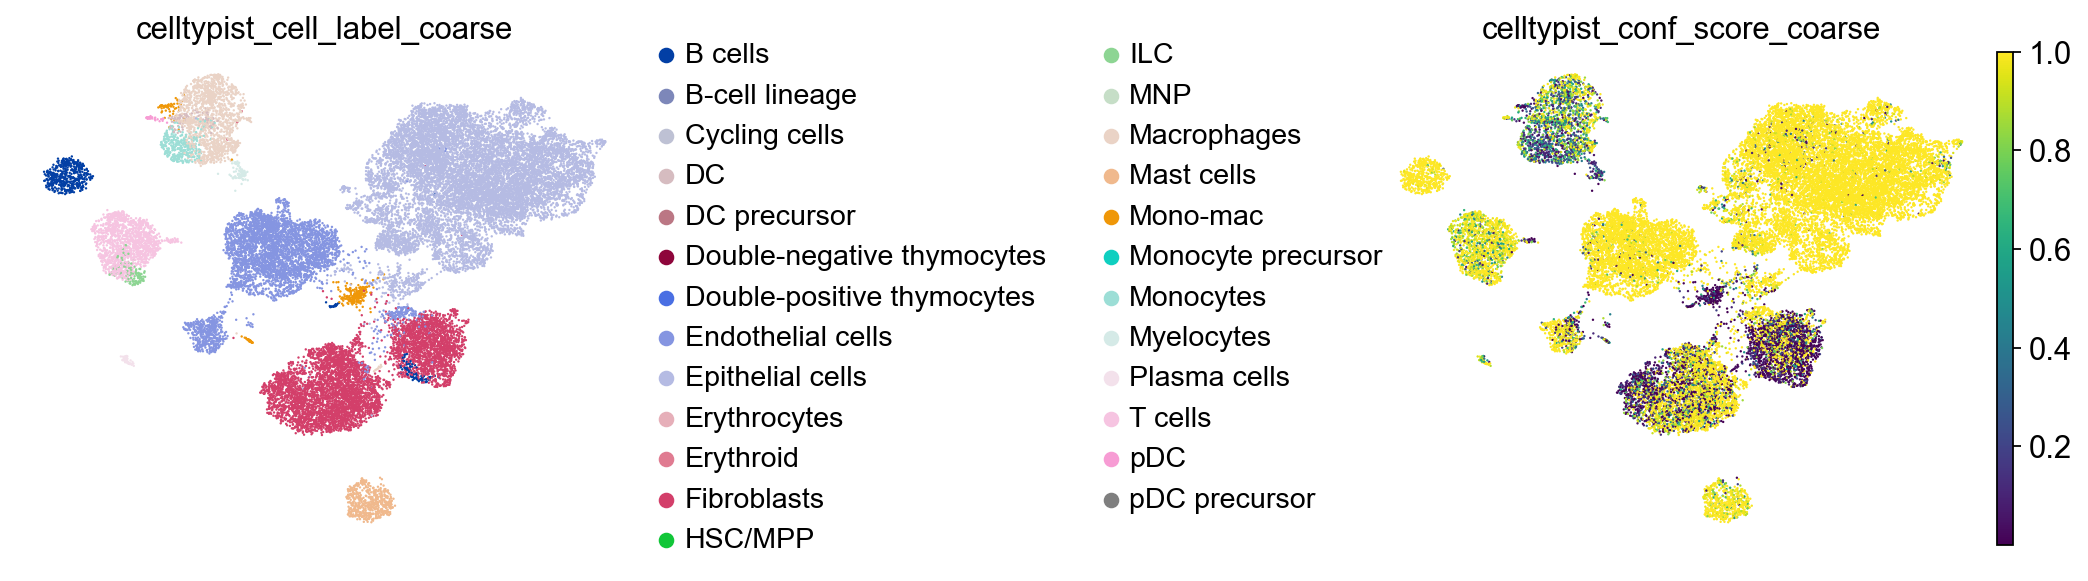

In [61]:
# 11.4 可视化结果
# 11.4.1 绘制UMAP图，显示高分辨率细胞类型信息和置信度分数
sc.pl.umap(adata, color=["celltypist_cell_label_coarse", "celltypist_conf_score_coarse"], frameon=False, sort_order=False, wspace=1)

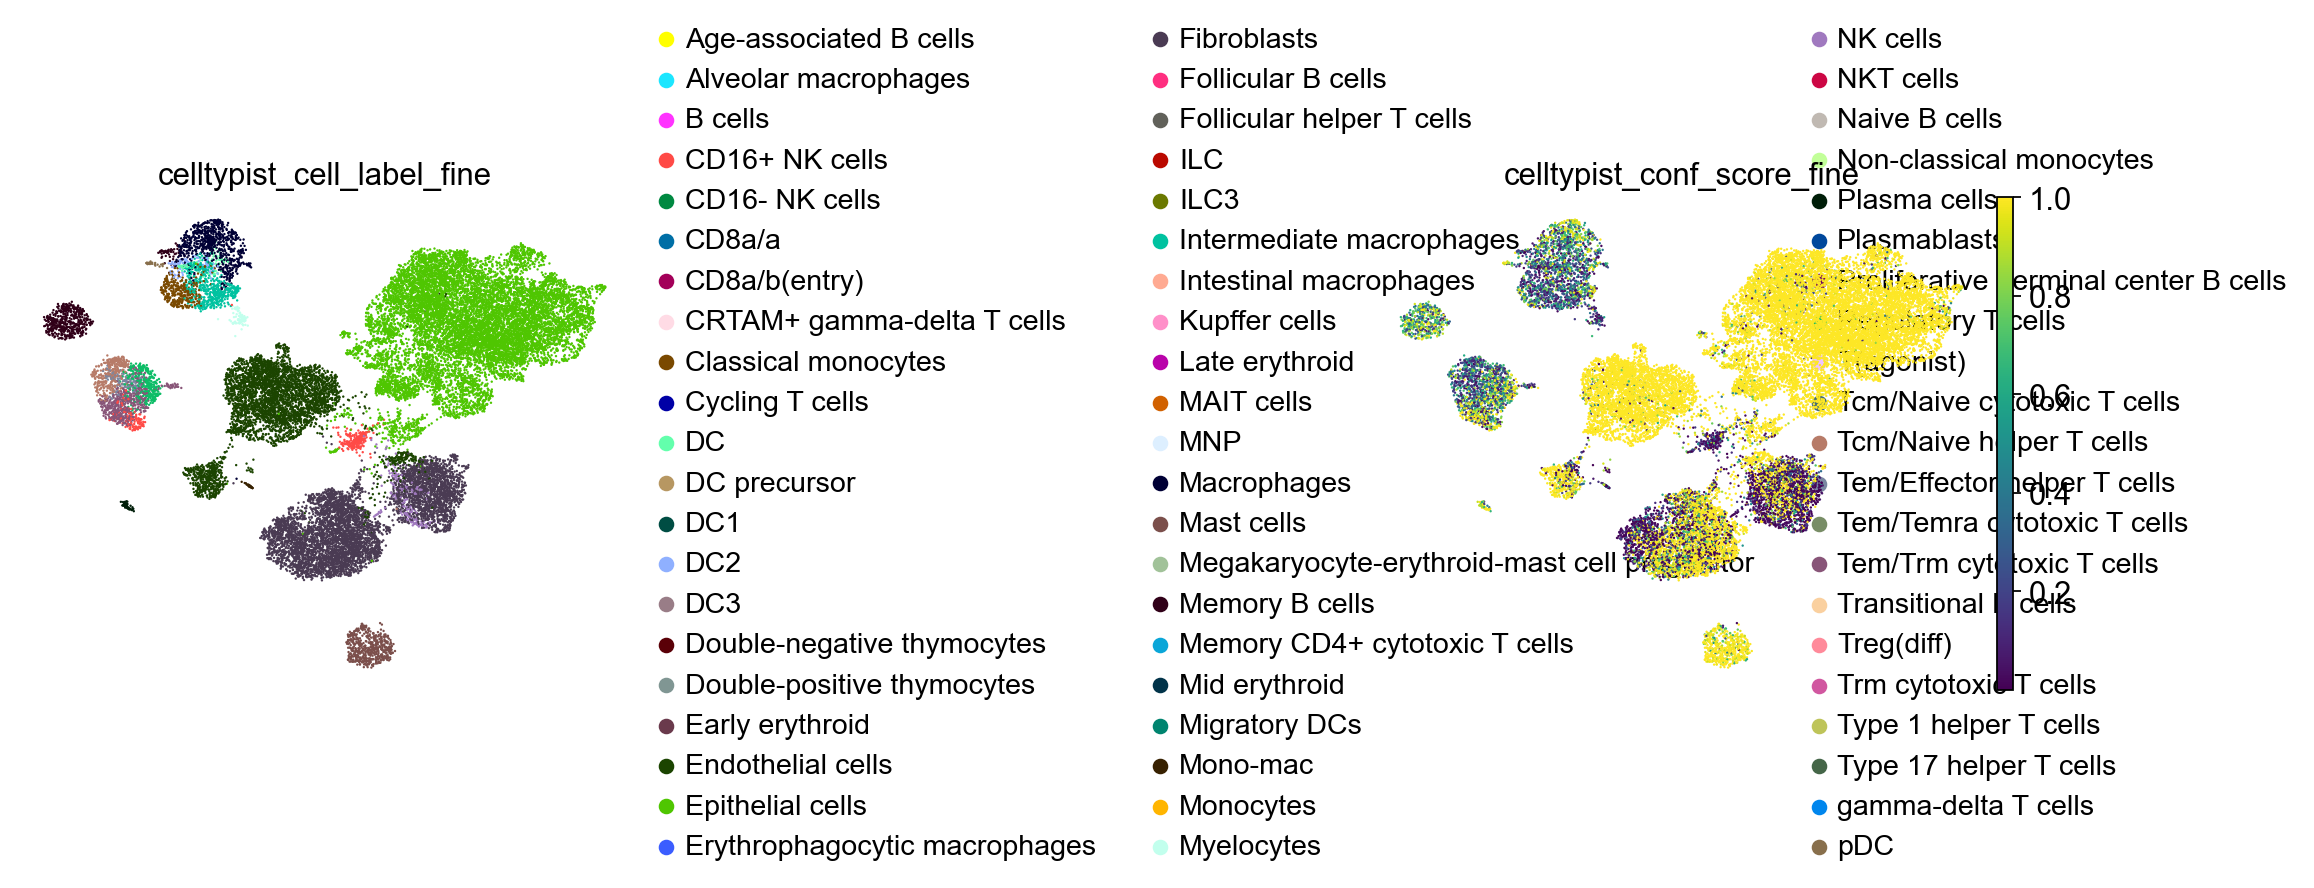

In [62]:
# 11.4.2 绘制UMAP图，显示低分辨率细胞类型信息和置信度分数
sc.pl.umap(adata, color=["celltypist_cell_label_fine", "celltypist_conf_score_fine"], frameon=False, sort_order=False, wspace=1)

In [63]:
# 11.4.3 TODO: 聚类树偶尔报错的
# sc.pl.dendrogram(adata, groupby="celltypist_cell_label_fine")

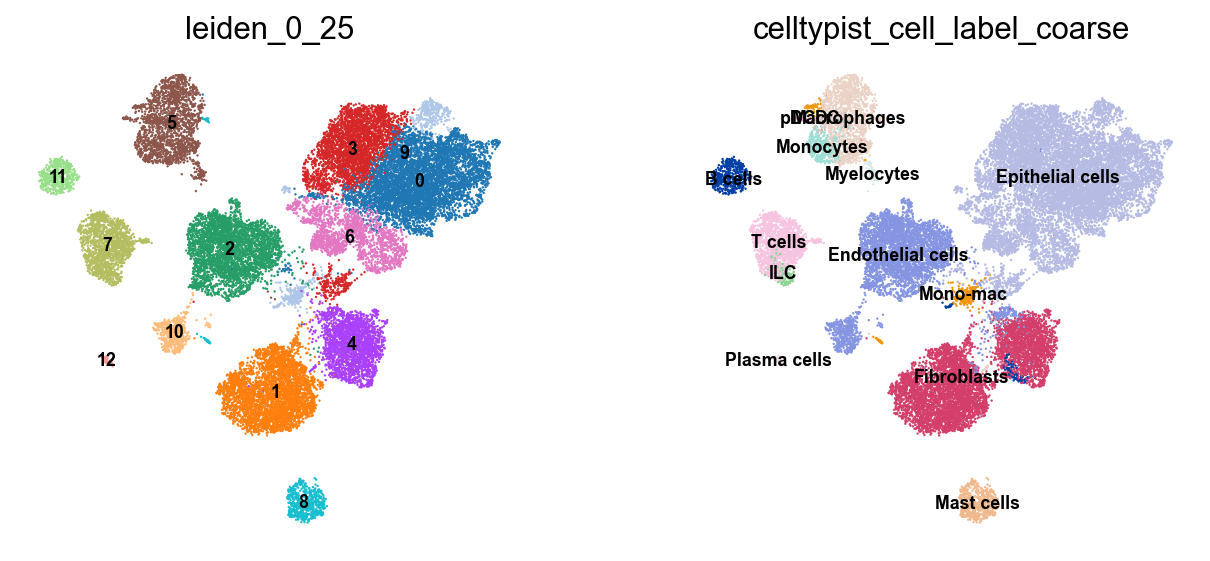

In [64]:
# 11.5 分析之前的手动注释
# 显示之前手动注释的细胞类型信息
sc.pl.umap(
    adata, 
    color=["leiden_0_25"]+["celltypist_cell_label_coarse"],
    legend_loc="on data",
    legend_fontsize=8,
    ncols=2,
    frameon=False
    )

In [65]:
# 11.6 进一步分析
# 用于分析Leiden社区的交叉表格
# 看每个聚类的个细胞占比
pd.crosstab(adata.obs.leiden_0_25, adata.obs.celltypist_cell_label_fine).loc["0", :].sort_values(ascending=False)

celltypist_cell_label_fine
Epithelial cells               5847
Macrophages                       1
CD16+ NK cells                    0
Mono-mac                          0
Tem/Trm cytotoxic T cells         0
Tem/Effector helper T cells       0
Tcm/Naive helper T cells          0
Regulatory T cells                0
Plasma cells                      0
NK cells                          0
Myelocytes                        0
Memory B cells                    0
Classical monocytes               0
Mast cells                        0
Intermediate macrophages          0
Fibroblasts                       0
Endothelial cells                 0
DC2                               0
DC                                0
pDC                               0
Name: 0, dtype: int64

In [66]:
# 11.7 保存
adata.write("anndata_celltypist_anno.h5ad", compression="gzip") # type: ignore